# Share Bike Demand Prediction
A share-bike company wants to understand the factors that impact the rental of their bikes, and predict the demand for their bikes under different conditions. Specially, they want to know:
   - which features are significant in predicting the demand for their shared bikes?
   - how the demand is correlated to the above factors?
  
For this purpose, a dataset of the share-bike rentals are provided containing the count of rental bikes for different values of features including temperature, humidity, wind speed, year, month, season, holidays, etc.
  
The objective is to analyse the data, develop a linear regression model, if applicable at all, and advise the business with feedback on the above business problems.

In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [2]:
def cat_col_to_dummy(df, col):
    """
    This function creates the required dummay columns for the df corresponding to a supplied categorical column
    Adds the dummy df to the current df, and deletes the original (supplied) categorical column
    """
    dummy_df = pd.get_dummies(df[col], drop_first = True)
    df = pd.concat([df, dummy_df], axis = 1)
    df = df.drop(col, axis = 1)
    return df

# Step 1: Importing, Understanding the Data, and EDA

In [3]:
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Dropping some of the columns that are not needed for the analysis and model building

In [4]:
df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


- 730 rows in the dataset
- None of the columns have null values. 
- Also, the type of the columns are as expected, based on the observation of the head() of the dataframe.
- **dependent variable**: 'cnt' or the target variable
- **independent variable**: the rest of the variables (features)
  
Below, to check the shape of the dataframe, and check if there are any probable duplicated rows.

In [6]:
df.shape

(730, 12)

In [7]:
df.drop_duplicates(inplace = True)

In [8]:
df.shape

(730, 12)

- No duplicated rows were observed.

In [9]:
# different columns types: categorical (cat_cols) and numeric (num_cols) columns
cat_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
num_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

## EDA
  
#### 'cnt' vs 'season'
  
Finding the unique values of the column and then renaming the values based on the advised values in the data dictionary.

In [10]:
df['season'].unique()

array([1, 2, 3, 4], dtype=int64)

In [11]:
df['season'] = df['season'].apply(lambda x: 'spring' if x == 1 else 'summer' if x == 2 else 'fall' if x == 3 else 'winter')

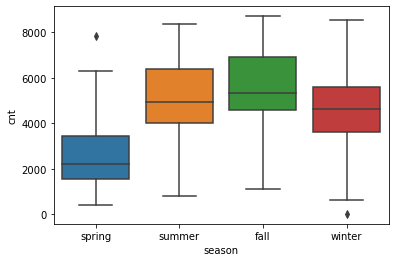

In [12]:
sns.boxplot(data=df, x='season', y='cnt')
plt.show()

The bike rentals during fall and summer (warm seasons) are higher than the rentals during winter and spring seasons (colder seasons), which is logical. Therefore, the season is clearly contributing to the target variabl (cnt, bike rental count). 
  
#### 'cnt' vs 'yr'
  
Finding the unique values of the column and then renaming the values based on the advised values in the data dictionary.

In [13]:
df['yr'].unique()

array([0, 1], dtype=int64)

In [14]:
df['yr'] = df['yr'].apply(lambda x: '2018' if x == 0 else '2019')

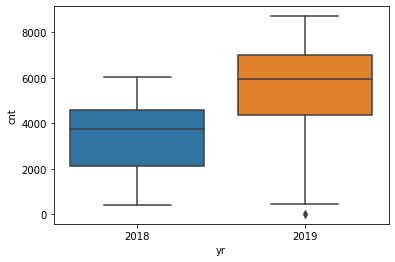

In [15]:
sns.boxplot(data=df, x='yr', y='cnt')
plt.show()

As can be seen by opening the economy during 2019, the bike rentals are higher than the previous year, i.e. 2018 during lockdown. Therefore, the year is also contributing to the target variable (cnt).
  
#### 'cnt' vs 'mnth'
  
Finding the unique values of the column and then renaming the values based on the advised values in the data dictionary.

In [16]:
df['mnth'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [17]:
df['mnth'] = df['mnth'].apply(lambda x: 'Jan' if x == 1 
                              else 'Feb' if x == 2 
                              else 'Mar' if x == 3 
                              else 'Apr' if x == 4 
                              else 'May' if x == 5 
                              else 'Jun' if x == 6
                              else 'Jul' if x == 7
                              else 'Aug' if x == 8
                              else 'Sep' if x == 9
                              else 'Oct' if x == 10
                              else 'Nov' if x == 11
                              else 'Dec')

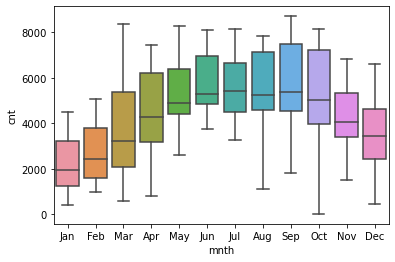

In [18]:
sns.boxplot(data=df, x='mnth', y='cnt')
plt.show()

Bike rentals during warmer months is higher than the colder months. Therefore, 'mnth' is also contributing to the target variable.
  
#### 'cnt' vs 'holiday'
  
Finding the unique values of the column and then renaming the values based on the advised values in the data dictionary.

In [19]:
df['holiday'].unique()

array([0, 1], dtype=int64)

In [20]:
df['holiday'] = df['holiday'].apply(lambda x: 'holiday' if x == 1 else 'non-holiday')

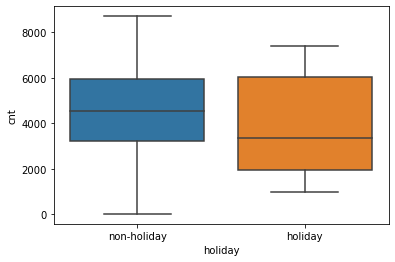

In [21]:
sns.boxplot(data=df, x='holiday', y='cnt')
plt.show()

The whole range of variation of cnt, the mean values and the IQR range are different for the holidays and non-holidays. Therefore, 'holiday' is also contributing to the target variable.
  
#### 'cnt' vs 'weekday'
  
Finding the unique values of the column and then renaming the values based on the advised values in the data dictionary.

In [22]:
df['weekday'].unique()

array([6, 0, 1, 2, 3, 4, 5], dtype=int64)

In [23]:
df['weekday'] = df['weekday'].apply(lambda x: 'Mon' if x == 0 
                                    else 'Tue' if x == 1
                                    else 'Wed' if x == 2
                                    else 'Thu' if x == 3
                                    else 'Fri' if x == 4
                                    else 'Sat' if x == 5
                                    else 'Sun')

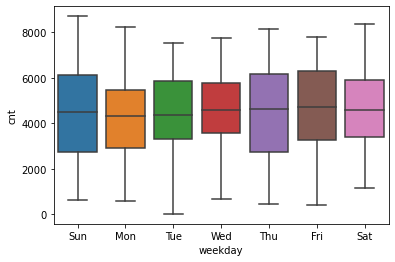

In [24]:
sns.boxplot(data=df, x='weekday', y='cnt')
plt.show()

The value of the target variable is slightly different across different days. Although the correlation is not as strong as other features, 'weekday' is kept for now and let RFE decide to choose the most important features.
  
#### 'cnt' vs 'workingday'
  
Finding the unique values of the column and then renaming the values based on the advised values in the data dictionary.

In [25]:
df['workingday'].unique()

array([0, 1], dtype=int64)

In [26]:
df['workingday'] = df['workingday'].apply(lambda x: 'working-day' if x == 1 else 'non-working-day')

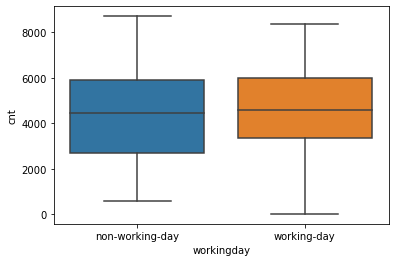

In [27]:
sns.boxplot(data=df, x='workingday', y='cnt')
plt.show()

The range of variation of cnt and the mean value accross these 2 categories are almost the same, although the IQR range is slightly larger for non-working-days compared to the working-days. The correlation seems to be not strong as compared to the previous features, however, 'workingday' is kept for now and let RFE decide to choose or drop this feature.
  
#### 'cnt' vs 'weathersit'
  
Finding the unique values of the column and then renaming the values based on the advised values in the data dictionary.

In [28]:
df['weathersit'].unique()

array([2, 1, 3], dtype=int64)

In [29]:
df['weathersit'] = df['weathersit'].apply(lambda x: 'clear' if x == 1 
                                    else 'mist+clouds' if x == 2
                                    else 'snow')

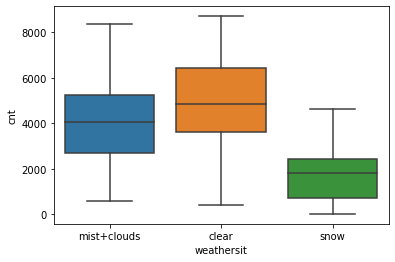

In [30]:
sns.boxplot(data=df, x='weathersit', y='cnt')
plt.show()

As can be seen, during a clear weather or mist+clouds weather situation the rentals are higher than snow weather. Therefore, weathersit is also contributing to the target variable.
  
#### 'cnt' vs numeric features

In [31]:
df.describe() # for the numeric features

,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,4508.006849
std,7.506729,8.150308,14.237589,5.195841,1936.011647
min,2.424346,3.953480,0.000000,1.500244,22.000000
25%,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,5966.000000
max,35.328347,42.044800,97.250000,34.000021,8714.000000


The values within all numeric columns are within acceptable and reasonable ranges. There seems to be **no outliers**.

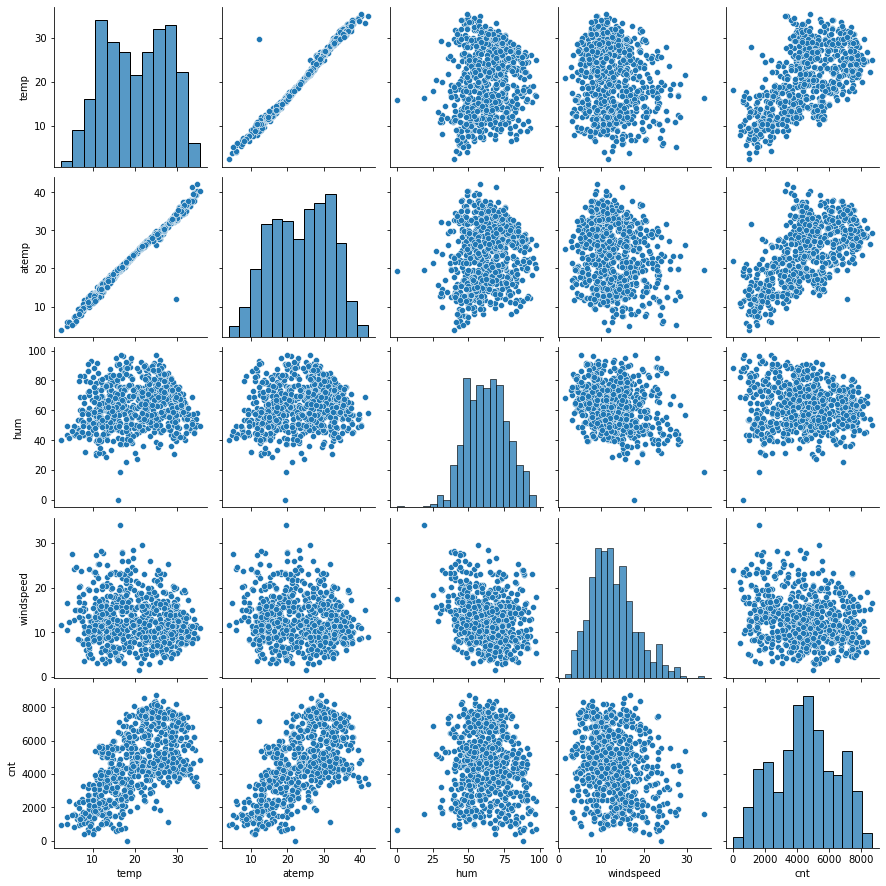

In [32]:
sns.pairplot(df[num_cols])
plt.show()

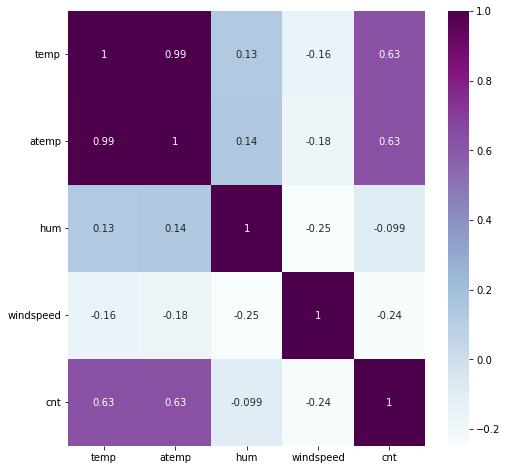

In [33]:
fig = plt.figure(figsize = (8,8))
sns.heatmap(df[num_cols].corr(), cmap = 'BuPu', annot=True)
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.show()

Inspection of the pairplots and the heatmap of the correlations reveals that:
- There is strong positive linear correlation between (temp and cnt), and (atemp and cnt) and less strong negative correlation between (hum and cnt) and (windspeed and cnt).
- The absolute value of the correlation between (windspeed and cnt) is much higher than the correlation between (hum and cnt).
- Also, it can be seen that temp and atemp are highly linearly correlated. This means that either of these can be dropped, however, it is up to RFE to choose the most important features during model building.

  
#### Need to consider a Multiple Linear Regression (MLR) model?
Investigating the categorical and numeric columns show that there is some linearity between some of the features (numeric and categorical) and the target (cnt). Therefore, a Multiple Linear Regression (MLR) model should be considered and implemented.
  
  
# Step 2: Data Preparation for Building Model
In this step the following have been implemented:
- dummy variables (columns) for the categorical columns are created and the original categorical columns were dropped.
- the dataframe has been split into train dataframe and test dataframes.
- the normal scaling (Min-Max scaling) is applied to the numeric columns of the train dataframe, since the rest of the columns are 0/1 's from dummy variables.
- dependent feature (y_train) and independant dataframe (x_train) has been created.

In [34]:
for col in cat_cols:
    df = cat_col_to_dummy(df, col)

In [35]:
df_train, df_test = train_test_split(df, train_size = 0.7, random_state =  100)

In [36]:
scaler = MinMaxScaler()
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])

In [37]:
df_train.describe()

,temp,atemp,hum,windspeed,cnt,spring,summer,winter,2019,Aug,...,non-holiday,Mon,Sat,Sun,Thu,Tue,Wed,working-day,mist+clouds,snow
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,0.247059,0.507843,0.096078,...,0.974510,0.143137,0.127451,0.154902,0.158824,0.150980,0.131373,0.676471,0.345098,0.029412
std,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,0.431725,0.500429,0.294988,...,0.157763,0.350557,0.333805,0.362166,0.365870,0.358381,0.338139,0.468282,0.475867,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
y_train = df_train.pop('cnt')
x_train = df_train

# Step 3: Model Building and Training
In this step the folowing have been implemented:
- RFE from sklearn is applied to choose the 20 most important features from the available features.
- Then, the 20 selected features are fine tuned (dropped) through stats model by closely monitoring the p-values and VIFs. This step is explained at each variable drop stage to mention the reason each feature has been dropped.

In [39]:
lrm = LinearRegression()
lrm.fit(x_train, y_train)
rfe = RFE(lrm, 20)
rfe = rfe.fit(x_train, y_train)

In [40]:
list(zip(x_train.columns, rfe.support_, rfe.ranking_))

[('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('2019', True, 1),
 ('Aug', False, 2),
 ('Dec', True, 1),
 ('Feb', True, 1),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 8),
 ('Mar', False, 10),
 ('May', True, 1),
 ('Nov', True, 1),
 ('Oct', False, 7),
 ('Sep', True, 1),
 ('non-holiday', True, 1),
 ('Mon', False, 3),
 ('Sat', False, 6),
 ('Sun', True, 1),
 ('Thu', False, 9),
 ('Tue', False, 4),
 ('Wed', False, 5),
 ('working-day', True, 1),
 ('mist+clouds', True, 1),
 ('snow', True, 1)]

Step below, to take the features that RFE is supporting. The title of the 20 columns selected by RFE are displayed.

In [41]:
cols =[x_train.columns[i] for i in range(len(x_train.columns)) if rfe.support_[i] == True]
cols

['temp',
 'atemp',
 'hum',
 'windspeed',
 'spring',
 'summer',
 'winter',
 '2019',
 'Dec',
 'Feb',
 'Jan',
 'Jul',
 'May',
 'Nov',
 'Sep',
 'non-holiday',
 'Sun',
 'working-day',
 'mist+clouds',
 'snow']

### stats model training and summary (very first step, for the 20 columns selected by RFE)

In [42]:
x_train_rfe = x_train[cols]
x_train_sm = sm.add_constant(x_train_rfe)
lm = sm.OLS(y_train, x_train_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     140.3
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          6.28e-188
Time:                        18:40:45   Log-Likelihood:                 525.41
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     489   BIC:                            -919.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2483      0.045      5.469      0.000       0.159       0.338
temp            0.4267      0.134      3.194      0.001       0.164       0.689
atemp           0.0273      0.135      0.202      0.840      -0.238       0.293
hum            -0.1542      0.038     -4.095      0.000      -0.228      -0.080
windspeed      -0.1862      0.026     -7.183      0.000      -0.237      -0.135
spring         -0.0559      0.022     -2.529      0.012      -0.099      -0.012
summer          0.0288      0.017      1.672      0.095      -0.005       0.063
winter          0.0994      0.018      5.477      0.000       0.064       0.135
2019            0.2318      0.008     29.075      0.000       0.216       0.247
Dec            -0.0488      0.018     -2.692      0.007      -0.084      -0.013
Feb            -0.0347      0.021     -1.623      0.105      -0.077       0.007
Jan            -0.0649      0.021     -3.058      0.002      -0.107      -0.023
Jul            -0.0513      0.018     -2.849      0.005      -0.087      -0.016
May             0.0230      0.017      1.330      0.184      -0.011       0.057
Nov            -0.0461      0.019     -2.456      0.014      -0.083      -0.009
Sep             0.0721      0.017      4.322      0.000       0.039       0.105
non-holiday     0.0490      0.027      1.816      0.070      -0.004       0.102
Sun             0.0545      0.014      3.771      0.000       0.026       0.083
working-day     0.0441      0.011      3.849      0.000       0.022       0.067
mist+clouds    -0.0583      0.010     -5.643      0.000      -0.079      -0.038
snow           -0.2545      0.026     -9.724      0.000      -0.306      -0.203
==============================================================================
Omnibus:                       83.276   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.047
Skew:                          -0.790   Prob(JB):                     1.50e-51
Kurtosis:                       5.919   Cond. No.                         98.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### VIF inspection, corresponding to the above stats model

In [43]:
vif = pd.DataFrame()
vif['features'] = x_train_sm.columns
vif['VIF'] = [variance_inflation_factor(x_train_sm.values, i) for i in range(x_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,features,VIF
0,const,135.12
1,temp,59.59
2,atemp,53.94
5,spring,5.90
7,winter,4.02
6,summer,3.62
11,Jan,2.38
3,hum,1.97
18,working-day,1.88
10,Feb,1.87


Looking at the p-values and VIFs, it can be seen that 'atemp' has a high p-value and a high VIF. Hence, 'atemp' is dropped first.

In [44]:
# dropping 'atemp' with high p-value and high VIF
x = x_train_rfe.drop('atemp', axis = 1)
x_train_sm = sm.add_constant(x)
lm = sm.OLS(y_train, x_train_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     148.0
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          5.20e-189
Time:                        18:40:46   Log-Likelihood:                 525.39
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     490   BIC:                            -926.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2478      0.045      5.472      0.000       0.159       0.337
temp            0.4527      0.038     11.846      0.000       0.378       0.528
hum            -0.1538      0.038     -4.094      0.000      -0.228      -0.080
windspeed      -0.1873      0.025     -7.371      0.000      -0.237      -0.137
spring         -0.0553      0.022     -2.528      0.012      -0.098      -0.012
summer          0.0295      0.017      1.747      0.081      -0.004       0.063
winter          0.1001      0.018      5.618      0.000       0.065       0.135
2019            0.2318      0.008     29.103      0.000       0.216       0.247
Dec            -0.0488      0.018     -2.692      0.007      -0.084      -0.013
Feb            -0.0348      0.021     -1.626      0.105      -0.077       0.007
Jan            -0.0650      0.021     -3.067      0.002      -0.107      -0.023
Jul            -0.0510      0.018     -2.844      0.005      -0.086      -0.016
May             0.0229      0.017      1.325      0.186      -0.011       0.057
Nov            -0.0461      0.019     -2.456      0.014      -0.083      -0.009
Sep             0.0723      0.017      4.349      0.000       0.040       0.105
non-holiday     0.0492      0.027      1.827      0.068      -0.004       0.102
Sun             0.0544      0.014      3.774      0.000       0.026       0.083
working-day     0.0441      0.011      3.852      0.000       0.022       0.067
mist+clouds    -0.0583      0.010     -5.655      0.000      -0.079      -0.038
snow           -0.2549      0.026     -9.773      0.000      -0.306      -0.204
==============================================================================
Omnibus:                       82.971   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.033
Skew:                          -0.787   Prob(JB):                     2.50e-51
Kurtosis:                       5.914   Cond. No.                         29.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# VIF inspection
vif = pd.DataFrame()
vif['features'] = x_train_sm.columns
vif['VIF'] = [variance_inflation_factor(x_train_sm.values, i) for i in range(x_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,features,VIF
0,const,134.74
4,spring,5.79
1,temp,4.88
6,winter,3.88
5,summer,3.49
10,Jan,2.38
2,hum,1.97
17,working-day,1.88
9,Feb,1.87
13,Nov,1.82


Then, 'May' is dropped which has a high p-value and low VIF.

In [46]:
# dropping 'May' with high p-value and low VIF
x.drop('May', axis = 1, inplace = True)
x_train_sm = sm.add_constant(x)
lm = sm.OLS(y_train, x_train_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     155.9
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          9.80e-190
Time:                        18:40:46   Log-Likelihood:                 524.48
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     491   BIC:                            -930.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2368      0.045      5.315      0.000       0.149       0.324
temp            0.4616      0.038     12.262      0.000       0.388       0.536
hum            -0.1477      0.037     -3.958      0.000      -0.221      -0.074
windspeed      -0.1889      0.025     -7.441      0.000      -0.239      -0.139
spring         -0.0515      0.022     -2.373      0.018      -0.094      -0.009
summer          0.0393      0.015      2.586      0.010       0.009       0.069
winter          0.1021      0.018      5.752      0.000       0.067       0.137
2019            0.2312      0.008     29.052      0.000       0.216       0.247
Dec            -0.0474      0.018     -2.619      0.009      -0.083      -0.012
Feb            -0.0334      0.021     -1.562      0.119      -0.075       0.009
Jan            -0.0634      0.021     -2.991      0.003      -0.105      -0.022
Jul            -0.0515      0.018     -2.868      0.004      -0.087      -0.016
Nov            -0.0444      0.019     -2.371      0.018      -0.081      -0.008
Sep             0.0723      0.017      4.346      0.000       0.040       0.105
non-holiday     0.0500      0.027      1.855      0.064      -0.003       0.103
Sun             0.0540      0.014      3.743      0.000       0.026       0.082
working-day     0.0442      0.011      3.860      0.000       0.022       0.067
mist+clouds    -0.0585      0.010     -5.668      0.000      -0.079      -0.038
snow           -0.2567      0.026     -9.849      0.000      -0.308      -0.206
==============================================================================
Omnibus:                       80.597   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.714
Skew:                          -0.784   Prob(JB):                     3.91e-47
Kurtosis:                       5.757   Cond. No.                         29.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# VIF inspection
vif = pd.DataFrame()
vif['features'] = x_train_sm.columns
vif['VIF'] = [variance_inflation_factor(x_train_sm.values, i) for i in range(x_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,features,VIF
0,const,130.20
4,spring,5.69
1,temp,4.73
6,winter,3.85
5,summer,2.82
10,Jan,2.37
2,hum,1.94
16,working-day,1.88
9,Feb,1.86
12,Nov,1.81


Then 'Feb' is dropped with high p-value ad low VIF.

In [48]:
# dropping 'Feb' with high p-value and low VIF
x.drop('Feb', axis = 1, inplace = True)
x_train_sm = sm.add_constant(x)
lm = sm.OLS(y_train, x_train_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.4
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          2.52e-190
Time:                        18:40:46   Log-Likelihood:                 523.22
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     492   BIC:                            -934.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2235      0.044      5.103      0.000       0.137       0.310
temp            0.4764      0.036     13.064      0.000       0.405       0.548
hum            -0.1494      0.037     -4.001      0.000      -0.223      -0.076
windspeed      -0.1879      0.025     -7.390      0.000      -0.238      -0.138
spring         -0.0607      0.021     -2.899      0.004      -0.102      -0.020
summer          0.0424      0.015      2.809      0.005       0.013       0.072
winter          0.1038      0.018      5.845      0.000       0.069       0.139
2019            0.2309      0.008     28.978      0.000       0.215       0.247
Dec            -0.0388      0.017     -2.248      0.025      -0.073      -0.005
Jan            -0.0455      0.018     -2.548      0.011      -0.081      -0.010
Jul            -0.0524      0.018     -2.916      0.004      -0.088      -0.017
Nov            -0.0399      0.019     -2.152      0.032      -0.076      -0.003
Sep             0.0737      0.017      4.430      0.000       0.041       0.106
non-holiday     0.0520      0.027      1.931      0.054      -0.001       0.105
Sun             0.0548      0.014      3.794      0.000       0.026       0.083
working-day     0.0444      0.011      3.870      0.000       0.022       0.067
mist+clouds    -0.0583      0.010     -5.637      0.000      -0.079      -0.038
snow           -0.2555      0.026     -9.791      0.000      -0.307      -0.204
==============================================================================
Omnibus:                       76.194   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.529
Skew:                          -0.745   Prob(JB):                     2.85e-44
Kurtosis:                       5.687   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# VIF inspection
vif = pd.DataFrame()
vif['features'] = x_train_sm.columns
vif['VIF'] = [variance_inflation_factor(x_train_sm.values, i) for i in range(x_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,features,VIF
0,const,125.47
4,spring,5.27
1,temp,4.43
6,winter,3.83
5,summer,2.77
2,hum,1.94
15,working-day,1.88
14,Sun,1.79
11,Nov,1.77
9,Jan,1.68


Since p-value more than 5% (0.05) is considered as high, then 'non-holiday' is dropped with high p-value (of 0.054) and low VIF.

In [50]:
# dropping 'non-holiday' with high p-value and low VIF
x.drop('non-holiday', axis = 1, inplace = True)
x_train_sm = sm.add_constant(x)
lm = sm.OLS(y_train, x_train_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     173.5
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          1.20e-190
Time:                        18:40:46   Log-Likelihood:                 521.29
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     493   BIC:                            -936.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2690      0.037      7.267      0.000       0.196       0.342
temp            0.4744      0.037     12.978      0.000       0.403       0.546
hum            -0.1480      0.037     -3.952      0.000      -0.222      -0.074
windspeed      -0.1883      0.025     -7.386      0.000      -0.238      -0.138
spring         -0.0624      0.021     -2.974      0.003      -0.104      -0.021
summer          0.0421      0.015      2.783      0.006       0.012       0.072
winter          0.1038      0.018      5.832      0.000       0.069       0.139
2019            0.2311      0.008     28.929      0.000       0.215       0.247
Dec            -0.0398      0.017     -2.302      0.022      -0.074      -0.006
Jan            -0.0465      0.018     -2.596      0.010      -0.082      -0.011
Jul            -0.0514      0.018     -2.854      0.004      -0.087      -0.016
Nov            -0.0441      0.018     -2.390      0.017      -0.080      -0.008
Sep             0.0714      0.017      4.289      0.000       0.039       0.104
Sun             0.0625      0.014      4.493      0.000       0.035       0.090
working-day     0.0521      0.011      4.826      0.000       0.031       0.073
mist+clouds    -0.0581      0.010     -5.607      0.000      -0.078      -0.038
snow           -0.2552      0.026     -9.754      0.000      -0.307      -0.204
==============================================================================
Omnibus:                       82.403   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.435
Skew:                          -0.787   Prob(JB):                     4.10e-50
Kurtosis:                       5.867   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# VIF inspection
vif = pd.DataFrame()
vif['features'] = x_train_sm.columns
vif['VIF'] = [variance_inflation_factor(x_train_sm.values, i) for i in range(x_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,features,VIF
0,const,89.13
4,spring,5.26
1,temp,4.42
6,winter,3.83
5,summer,2.77
2,hum,1.94
11,Nov,1.75
9,Jan,1.68
14,working-day,1.66
13,Sun,1.65


Next, 'spring' is dropped with low p-value but high VIF (of more than 5).

In [52]:
# dropping 'spring' with low p-value and high VIF
x.drop('spring', axis = 1, inplace = True)
x_train_sm = sm.add_constant(x)
lm = sm.OLS(y_train, x_train_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     181.6
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          6.82e-190
Time:                        18:40:47   Log-Likelihood:                 516.76
No. Observations:                 510   AIC:                            -1002.
Df Residuals:                     494   BIC:                            -933.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2037      0.030      6.784      0.000       0.145       0.263
temp            0.5492      0.027     20.533      0.000       0.497       0.602
hum            -0.1600      0.038     -4.265      0.000      -0.234      -0.086
windspeed      -0.1969      0.026     -7.713      0.000      -0.247      -0.147
summer          0.0733      0.011      6.665      0.000       0.052       0.095
winter          0.1395      0.013     10.524      0.000       0.113       0.166
2019            0.2297      0.008     28.578      0.000       0.214       0.245
Dec            -0.0338      0.017     -1.952      0.051      -0.068       0.000
Jan            -0.0504      0.018     -2.801      0.005      -0.086      -0.015
Jul            -0.0411      0.018     -2.308      0.021      -0.076      -0.006
Nov            -0.0343      0.018     -1.877      0.061      -0.070       0.002
Sep             0.0864      0.016      5.402      0.000       0.055       0.118
Sun             0.0632      0.014      4.509      0.000       0.036       0.091
working-day     0.0528      0.011      4.857      0.000       0.031       0.074
mist+clouds    -0.0552      0.010     -5.307      0.000      -0.076      -0.035
snow           -0.2488      0.026     -9.468      0.000      -0.300      -0.197
==============================================================================
Omnibus:                       73.135   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.330
Skew:                          -0.749   Prob(JB):                     1.40e-38
Kurtosis:                       5.442   Cond. No.                         20.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# VIF inspection
vif = pd.DataFrame()
vif['features'] = x_train_sm.columns
vif['VIF'] = [variance_inflation_factor(x_train_sm.values, i) for i in range(x_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,features,VIF
0,const,57.71
1,temp,2.33
5,winter,2.09
2,hum,1.91
10,Nov,1.69
8,Jan,1.67
13,working-day,1.66
12,Sun,1.65
14,mist+clouds,1.56
7,Dec,1.48


Then, 'Nov' is dropped with high p-value and low VIF.

In [54]:
# dropping 'Nov' with high p-value and low VIF
x.drop('Nov', axis = 1, inplace = True)
x_train_sm = sm.add_constant(x)
lm = sm.OLS(y_train, x_train_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     193.3
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          2.76e-190
Time:                        18:40:47   Log-Likelihood:                 514.95
No. Observations:                 510   AIC:                            -999.9
Df Residuals:                     495   BIC:                            -936.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1959      0.030      6.571      0.000       0.137       0.254
temp            0.5582      0.026     21.164      0.000       0.506       0.610
hum            -0.1592      0.038     -4.233      0.000      -0.233      -0.085
windspeed      -0.1969      0.026     -7.695      0.000      -0.247      -0.147
summer          0.0747      0.011      6.790      0.000       0.053       0.096
winter          0.1268      0.011     11.089      0.000       0.104       0.149
2019            0.2297      0.008     28.507      0.000       0.214       0.246
Dec            -0.0214      0.016     -1.332      0.183      -0.053       0.010
Jan            -0.0456      0.018     -2.553      0.011      -0.081      -0.011
Jul            -0.0421      0.018     -2.358      0.019      -0.077      -0.007
Sep             0.0894      0.016      5.604      0.000       0.058       0.121
Sun             0.0640      0.014      4.551      0.000       0.036       0.092
working-day     0.0531      0.011      4.876      0.000       0.032       0.075
mist+clouds    -0.0547      0.010     -5.246      0.000      -0.075      -0.034
snow           -0.2457      0.026     -9.344      0.000      -0.297      -0.194
==============================================================================
Omnibus:                       70.968   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.157
Skew:                          -0.732   Prob(JB):                     5.04e-37
Kurtosis:                       5.392   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
# VIF inspection
vif = pd.DataFrame()
vif['features'] = x_train_sm.columns
vif['VIF'] = [variance_inflation_factor(x_train_sm.values, i) for i in range(x_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,features,VIF
0,const,56.61
1,temp,2.26
2,hum,1.91
12,working-day,1.66
11,Sun,1.65
8,Jan,1.63
13,mist+clouds,1.56
5,winter,1.55
4,summer,1.43
9,Jul,1.43


Next, 'Dec' is dropped with high p-value and low VIF.

In [56]:
# dropping 'Dec' with high p-value and low VIF
x.drop('Dec', axis = 1, inplace = True)
x_train_sm = sm.add_constant(x)
lm = sm.OLS(y_train, x_train_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     207.7
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          4.53e-191
Time:                        18:40:47   Log-Likelihood:                 514.04
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     496   BIC:                            -940.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1907      0.030      6.447      0.000       0.133       0.249
temp            0.5684      0.025     22.506      0.000       0.519       0.618
hum            -0.1643      0.037     -4.387      0.000      -0.238      -0.091
windspeed      -0.1943      0.026     -7.609      0.000      -0.244      -0.144
summer          0.0765      0.011      6.997      0.000       0.055       0.098
winter          0.1251      0.011     11.000      0.000       0.103       0.147
2019            0.2296      0.008     28.473      0.000       0.214       0.245
Jan            -0.0401      0.017     -2.306      0.022      -0.074      -0.006
Jul            -0.0429      0.018     -2.402      0.017      -0.078      -0.008
Sep             0.0909      0.016      5.715      0.000       0.060       0.122
Sun             0.0629      0.014      4.476      0.000       0.035       0.090
working-day     0.0526      0.011      4.824      0.000       0.031       0.074
mist+clouds    -0.0538      0.010     -5.172      0.000      -0.074      -0.033
snow           -0.2425      0.026     -9.253      0.000      -0.294      -0.191
==============================================================================
Omnibus:                       67.331   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.535
Skew:                          -0.705   Prob(JB):                     2.77e-34
Kurtosis:                       5.298   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
# VIF inspection
vif = pd.DataFrame()
vif['features'] = x_train_sm.columns
vif['VIF'] = [variance_inflation_factor(x_train_sm.values, i) for i in range(x_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,features,VIF
0,const,55.65
1,temp,2.07
2,hum,1.89
11,working-day,1.65
10,Sun,1.64
12,mist+clouds,1.56
7,Jan,1.55
5,winter,1.53
8,Jul,1.43
4,summer,1.41


The next step would be to drop 'const' with low p-value and high VIF, however, statsmodel throws error and doesn't work without 'const'. Therefore, this model will be considered as the MLR model for the problem.  
  
  
As was observed during the feature drop stage:
- the R squared decreased from 0.852 (for 20 features selected by RFE) to 0.845 (in the final MLR model).
- the Adjusted R squared increased from 0.846 (for 20 features selected by RFE) to 0.841 (in the final MLR model).  
  
This means this final model captures 84.5% of the variance in the target variable by the available features.
  
All the available features have:
- very low p-values, meaning they are all significant;
- and low VIFs, meaning they are all independent of each other.

# Step 4: Residual Analysis

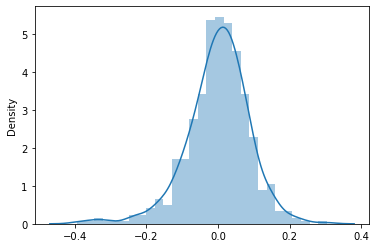

In [58]:
y_train_pred = lm.predict(x_train_sm)
res = y_train - y_train_pred
sns.distplot(res)
plt.show()

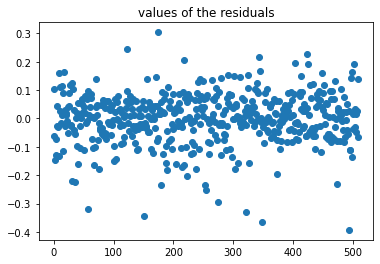

In [59]:
x_plt = np.array(list(range(len(res))))
plt.scatter(x_plt, res)
plt.title('values of the residuals')
plt.show()

Analysis of the histogram and the scatter plot of the residuals reveals that:
- the residuals follow a normal distribution with a mean of zero, as expected as one of the conditions of the MLR assumptions.
- the residuals are scattered around 0, and are independent of each other.
- the residuals have constant variance (homoscedasticity).
  
  
# Step 5: Predictions (on test set) and Model Evaluation

In [60]:
df_test[num_cols] = scaler.transform(df_test[num_cols])

In [61]:
df_test.describe()

,temp,atemp,hum,windspeed,cnt,spring,summer,winter,2019,Aug,...,non-holiday,Mon,Sat,Sun,Thu,Tue,Wed,working-day,mist+clouds,snow
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,0.236364,0.481818,0.059091,...,0.963636,0.145455,0.177273,0.118182,0.100000,0.127273,0.168182,0.700000,0.318182,0.027273
std,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,0.425817,0.500809,0.236333,...,0.187620,0.353363,0.382770,0.323559,0.300684,0.334038,0.374881,0.459303,0.466833,0.163248
min,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The Min-Max scaler has been fitted on the train set not the test set, and hence the min and max of the values are not 0, and 1, respectively, as was expected.

In [62]:
y_test = df_test.pop('cnt')
x_test = df_test[x.columns]

In [63]:
x_test_sm = sm.add_constant(x_test)
y_test_pred = lm.predict(x_test_sm)

In [64]:
print(r2_score(y_true = y_test, y_pred = y_test_pred))

0.8050619040775491


As can be seen, the R squared value of the test set is 80.5%, which is slightly different from the R squared value of the training set (84.5%), which is acceptable due to the insignificant difference between these two values. Therefore, it can be concluded that this model is able to generalise the results, and is not over-fitted to the train set.
  
  
# Answer to the Business Problem

To answer the qusetions raised by the business problem:
- the top 3 predictors for share bike rentals are: temperature (temp), snow conditions (snow) and the year 2019.
- the equation for interpreting the rental counts based on the above variables is:  
### $ bike \space rentals = 0.5684 \times temp -0.2425 \times snow + 0.2296 \times "2019" + the \space rest \space of \space the \space multipliers \space and \space features $  
This means:
    - 1 unit increase in temperature (without increase in the rest of the features) increases the bike rentals by 0.56 units.
    - 1 unit increase in snow conditions, on the other hand, decreases the bike rentals by 0.24 units.

# Acknowledgement
- I would like to acknowledge the feedback, support and dataset provision by [upGrad](https://www.upgrad.com/gb) and The [International Institute of Information Technology (IIIT), Bangalore](https://www.iiitb.ac.in/).  
- Also, I would like to express my gratitude to [Nishan Ali](https://www.linkedin.com/in/nishan-ali-826552166/) for providing clarification and guidance to carry out this project.   
- The dataset of this paper was used and is acknowledged: Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3. 
- Furthermore, the valuable feedback from [Dr Tayeb Jamali](https://www.linkedin.com/in/tayeb-jamali-b1a10937/) is highly appreciated.